# How to create branches for parallel node execution

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes">
                    Node
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#edges">
                    Edge
                </a>
            </li>            
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers">
                    Reducer
                </a>
            </li>
        </ul>
    </p>
</div> 

Parallel execution of nodes is essential to speed up overall graph operation. LangGraph offers native support for parallel execution of nodes, which can significantly enhance the performance of graph-based workflows. This parallelization is achieved through fan-out and fan-in mechanisms, utilizing both standard edges and [conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.add_conditional_edges). Below are some examples showing how to add create branching dataflows that work for you. 

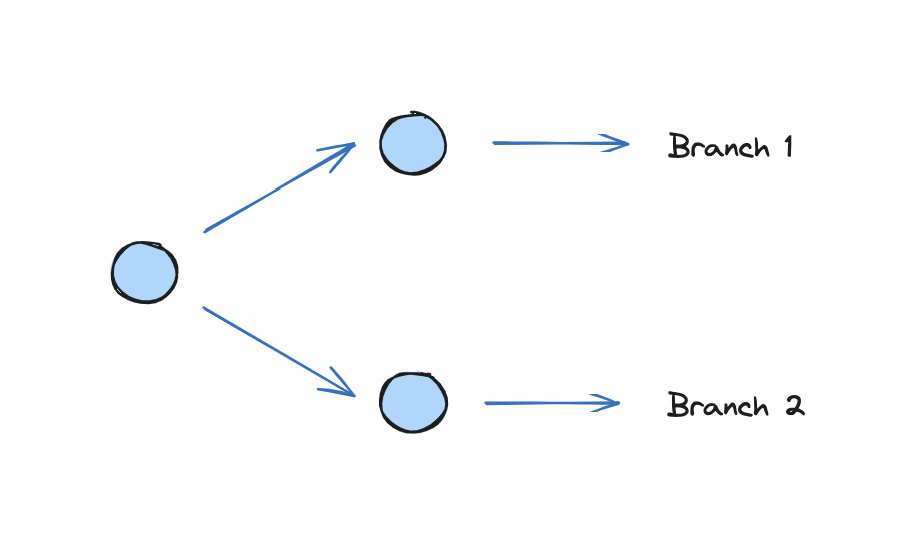

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## How to run graph nodes in parallel

In this example, we fan out from `Node A` to `B and C` and then fan in to `D`. With our state, [we specify the reducer add operation](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). This will combine or accumulate values for the specific key in the State, rather than simply overwriting the existing value. For lists, this means concatenating the new list with the existing list. See [this guide](../../how-tos/state-reducers) for more detail on updating state with reducers.

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

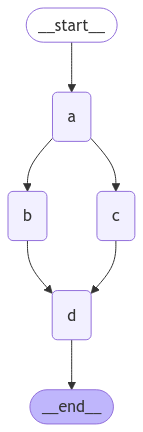

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

With the reducer, you can see that the values added in each node are accumulated.

In [8]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

!!! note

    In the above example, nodes `"b"` and `"c"` are executed concurrently in the same [superstep](../../concepts/low_level/#graphs). Because they are in the same step, node `"d"` executes after both `"b"` and `"c"` are finished.

    Importantly, updates from a parallel superstep may not be ordered consistently. If you need a consistent, predetermined ordering of updates from a parallel superstep, you should write the outputs to a separate field in the state together with a value with which to order them.

<details class="note"> <summary>Exception handling?</summary>
 <p>LangGraph executes nodes within <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs">"supersteps"</a>, meaning that while parallel branches are executed in parallel, the entire superstep is <b>transactional</b>. If any of these branches raises an exception, <b>none</b> of the updates are applied to the state (the entire superstep errors).</p>
<p>Importantly, when using a <a href="https://langchain-ai.github.io/langgraph/concepts/persistence/">checkpointer</a>, results from successful nodes within a superstep are saved, and don't repeat when resumed.</p>
 If you have error-prone (perhaps want to handle flakey API calls), LangGraph provides two ways to address this:<br>
 <ol>
  <li>You can write regular python code within your node to catch and handle exceptions.</li>
  <li>You can set a <b><a href="https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy">retry_policy</a></b> to direct the graph to retry nodes that raise certain types of exceptions. Only failing branches are retried, so you needn't worry about performing redundant work.</li>
</ol></p>
Together, these let you perform parallel execution and fully control exception handling.
</details>

## Parallel node fan-out and fan-in with extra steps

The above example showed how to fan-out and fan-in when each path was only one step. But what if one path had more than one step? Let's add a node `b_2` in the "b" branch:

In [4]:
def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
# highlight-next-line
builder.add_edge(["b_2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

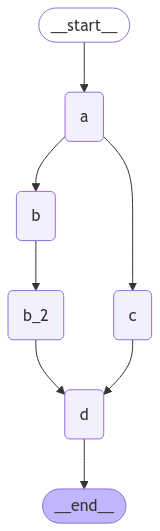

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"aggregate": []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

!!! note

    <p>In the above example, nodes `"b"` and `"c"` are executed concurrently in the same [superstep](../../concepts/low_level/#graphs). What happens in the next step?</p>
    <p>We use `add_edge(["b_2", "c"], "d")` here to force node `"d"` to only run when both nodes `"b_2"` and `"c"` have finished execution. If we added two separate edges,
    node `"d"` would run twice: after node `b2` finishes and once again after node `c` (in whichever order those nodes finish).</p>

## Conditional Branching

If your fan-out is not deterministic, you can use [add_conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph.add_conditional_edges) directly.

In [8]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()

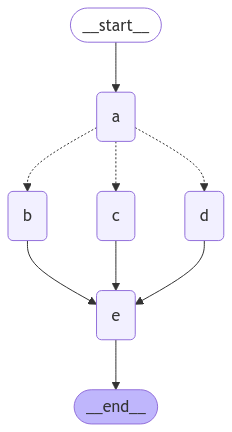

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [11]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

## Next steps

- Continue with the [Graph API Basics](../../how-tos/#graph-api-basics) guides.
- Learn how to create [map-reduce](../../how-tos/map-reduce/) branches in which different states can be distributed to multiple instances of a node.